In [1]:
import os
import scipy.misc
import scipy.io
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [9]:
!curl -o ../data/imagenet-vgg-verydeep-19.mat http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  549M  100  549M    0     0  4571k      0  0:02:03  0:02:03 --:--:-- 3564k


In [7]:
!curl -o ../data/book_cover.jpg https://raw.githubusercontent.com/nfmcclure/tensorflow_cookbook/master/08_Convolutional_Neural_Networks/images/book_cover.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92690  100 92690    0     0   273k      0 --:--:-- --:--:-- --:--:--  273k


In [6]:
!curl -o ../data/starry_night.jpg https://raw.githubusercontent.com/nfmcclure/tensorflow_cookbook/master/08_Convolutional_Neural_Networks/images/starry_night.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  549k  100  549k    0     0  1399k      0 --:--:-- --:--:-- --:--:-- 1401k


In [189]:
original_image_file = '../data/book_cover.jpg'
style_image_file = '../data/starry_night.jpg'
vgg_path = '../data/imagenet-vgg-verydeep-19.mat'
original_image_weight = 2000.0
style_image_weight = 8000.0
regularization_weight = 100
learning_rate = 0.001
generations = 10000
output_generations = 250

In [190]:
original_image = scipy.misc.imread(original_image_file)
style_image = scipy.misc.imread(style_image_file)
target_shape = original_image.shape
style_image = scipy.misc.imresize(style_image, target_shape[1] / style_image.shape[1])

/home/yskn67/.ghq/github.com/yskn67/tf_cookbook/tf_cookbook/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/home/yskn67/.ghq/github.com/yskn67/tf_cookbook/tf_cookbook/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/yskn67/.ghq/github.com/yskn67/tf_cookbook/tf_cookbook/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [191]:
vgg_layers = ['conv1_1', 'relu1_1',
              'conv1_2', 'relu1_2', 'pool1',
              'conv2_1', 'relu2_1',
              'conv2_2', 'relu2_2', 'pool2',
              'conv3_1', 'relu3_1',
              'conv3_2', 'relu3_2',
              'conv3_3', 'relu3_3',
              'conv3_4', 'relu3_4', 'pool3',
              'conv4_1', 'relu4_1',
              'conv4_2', 'relu4_2',
              'conv4_3', 'relu4_3',
              'conv4_4', 'relu4_4', 'pool4',
              'conv5_1', 'relu5_1',
              'conv5_2', 'relu5_2',
              'conv5_3', 'relu5_3',
              'conv5_4', 'relu5_4']

In [192]:
def extract_net_info(path_to_params):
    vgg_data = scipy.io.loadmat(path_to_params)
    normalization_matrix = vgg_data['normalization'][0][0][0]
    mat_mean = np.mean(normalization_matrix, axis=(0, 1))
    network_weights = vgg_data['layers'][0]
    return (mat_mean, network_weights)

In [193]:
def vgg_network(network_weights, init_image):
    network = {}
    image = init_image
    
    for i, layer in enumerate(vgg_layers):
        if layer[0] == 'c':
            weights, bias = network_weights[i][0][0][0][0]
            weights = np.transpose(weights, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            conv_layer = tf.nn.conv2d(image,
                                       tf.constant(weights),
                                       (1, 1, 1, 1),
                                       'SAME')
            image = tf.nn.bias_add(conv_layer, bias)
        elif layer[0] == 'r':
            image = tf.nn.relu(image)
        else:
            image = tf.nn.max_pool(image,
                                   (1, 2, 2, 1),
                                   (1, 2, 2, 1),
                                   'SAME')
        network[layer] = image
    return network

In [194]:
original_layer = 'relu4_2'
style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

In [195]:
normalization_mean, network_weights = extract_net_info(vgg_path)
shape = (1,) + original_image.shape
style_shape = (1,) + style_image.shape
original_features = {}
style_features = {}

In [196]:
with tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)
    vgg_net = vgg_network(network_weights, image)
    
    original_minus_mean = original_image - normalization_mean
    original_norm = np.array([original_minus_mean])
    original_features[original_layer] = sess.run(vgg_net[original_layer], feed_dict={image: original_norm})
    
    image = tf.placeholder('float', shape=style_shape)
    vgg_net = vgg_network(network_weights, image)
    
    style_minus_mean = style_image - normalization_mean
    style_norm = np.array([style_minus_mean])
    
    for layer in style_layers:
        layer_output = sess.run(vgg_net[layer], feed_dict={image: style_norm})
        layer_output = np.reshape(layer_output, (-1, layer_output.shape[3]))
        style_gram_matrix = np.matmul(layer_output.T, layer_output) / layer_output.size
        style_features[layer] = style_gram_matrix
    
    initial = tf.random_normal(shape) * 0.256
    image = tf.Variable(initial)
    vgg_net = vgg_network(network_weights, image)
    
    original_loss = original_image_weight * (2 * tf.nn.l2_loss(
        vgg_net[original_layer] - original_features[original_layer]) / original_features[original_layer].size
    )
    
    style_loss = 0
    style_losses = []
    for style_layer in style_layers:
        layer = vgg_net[style_layer]
        feats, height, width, channels = [x.value for x in layer.get_shape()]
        size = height * width *channels
        features = tf.reshape(layer, (-1, channels))
        style_gram_matrix = tf.matmul(tf.transpose(features), features) / size
        style_expected = style_features[style_layer]
        style_losses.append(2 * tf.nn.l2_loss(
            style_gram_matrix - style_expected) / style_expected.size)
    style_loss += style_image_weight * tf.reduce_sum(style_losses)
    
    total_var_x = sess.run(tf.reduce_prod(image[:, 1:, :, :].get_shape()))
    total_var_y = sess.run(tf.reduce_prod(image[:, :, 1:, :].get_shape()))
    first_term = regularization_weight * 2
    second_term_numerator = tf.nn.l2_loss(image[:, 1:, :, :] -
                                          image[:, :shape[1] - 1, :, :])
    second_term = second_term_numerator / total_var_y
    third_term = (tf.nn.l2_loss(image[:, :, 1:, :] - image[:, :, :shape[2] - 1, :]) /
                 total_var_x)
    total_variation_loss = first_term * (second_term + third_term)
    
    loss = original_loss + style_loss + total_variation_loss
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_step = optimizer.minimize(loss)
    
    sess.run(tf.global_variables_initializer())
    for i in range(generations):
        sess.run(train_step)
        
        if (i + 1) % output_generations == 0:
            print('Generation {} out of {}, loss: {}'.format(i + 1,
                                                            generations, sess.run(loss)))
    
    image_eval = sess.run(image)
    best_image_add_mean = image_eval.reshape(shape[1:]) + normalization_mean
    output_file = '../data/final_output.jpg'
    scipy.misc.imsave(output_file, best_image_add_mean)

Generation 250 out of 10000, loss: 554929408.0
Generation 500 out of 10000, loss: 455805408.0
Generation 750 out of 10000, loss: 415672448.0
Generation 1000 out of 10000, loss: 392243040.0
Generation 1250 out of 10000, loss: 376320160.0
Generation 1500 out of 10000, loss: 364543424.0
Generation 1750 out of 10000, loss: 355392480.0
Generation 2000 out of 10000, loss: 348066624.0
Generation 2250 out of 10000, loss: 341999872.0
Generation 2500 out of 10000, loss: 336962752.0
Generation 2750 out of 10000, loss: 332737376.0
Generation 3000 out of 10000, loss: 329186432.0
Generation 3250 out of 10000, loss: 326110688.0
Generation 3500 out of 10000, loss: 323440576.0
Generation 3750 out of 10000, loss: 321093440.0
Generation 4000 out of 10000, loss: 318993248.0
Generation 4250 out of 10000, loss: 317121056.0
Generation 4500 out of 10000, loss: 315441664.0
Generation 4750 out of 10000, loss: 313933184.0
Generation 5000 out of 10000, loss: 312572992.0
Generation 5250 out of 10000, loss: 3113251

/home/yskn67/.ghq/github.com/yskn67/tf_cookbook/tf_cookbook/lib/python3.6/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


### original

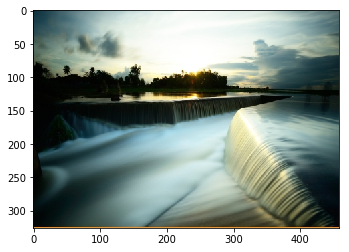

In [197]:
plt.imshow(original_image)

### style

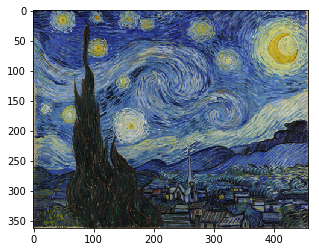

In [198]:
plt.imshow(style_image)

### output

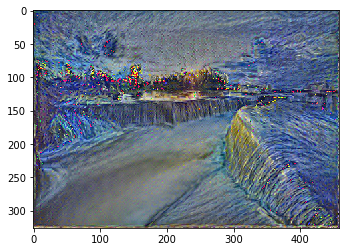

In [199]:
plt.imshow(best_image_add_mean.astype(np.uint8))